# PDF Fitting and Error bars

We start off by importing the required libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

# Required libraries for data arrays, data manipulation, plotting etc
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}",r'\boldmath']


#sns.set(style="white", palette="muted")
#sns.set_context("paper")


## Data Import

In [2]:
big_1 = pd.read_csv("../results", sep=" ")
big_1.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
0,0.01,50,0.5,0.1,0,1,49.4770,0.000000,100.8100,11.33220,761.60000,100.0000,7797
1,0.01,50,0.5,0.1,6,1,49.4352,-0.000002,103.4560,11.48000,791.78400,100.0000,828
2,0.01,50,0.5,0.1,12,1,49.2898,0.000295,101.9160,11.39430,774.17600,100.0000,2487
3,0.01,50,0.5,0.1,18,13,93.7334,-0.081582,10.3715,3.63485,25.13270,27.0941,190
4,0.01,50,0.5,0.1,18,12,84.5200,-0.878589,1.8992,1.55543,1.96938,9.2134,181


The **area** column is not actually area, but for the 3D axisymmetric solver, the `dv` volume element corresponds to volume per unit radian. Thus, all integral quantities (e.g. drop volume) need to be multiplied by a factor of $2\pi$. 

> The volume of the ligaments in our case are $\pi R^2 L$, where $R=1$. Thus, $\pi L$ gives us the initial ligament volume, where $L=2\Lambda$. 

In [4]:
# slicing the old dataset
# d1 : small amp - small aspect

d1 = big_1.loc[(big_1.amplitude == 0.1) & (big_1['aspect-ratio'] == 50)]

#viewing the new dataset
d1.head()

# Checking the volume of the ligaments at time T = 0, mean and std
d1.area.loc[d1.time == 0].mean() , d1.area.loc[d1.time == 0].std()


,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
0,0.01,50,0.5,0.1,0,1,49.4770,0.000000,100.8100,11.33220,761.60000,100.0000,7797
1,0.01,50,0.5,0.1,6,1,49.4352,-0.000002,103.4560,11.48000,791.78400,100.0000,828
2,0.01,50,0.5,0.1,12,1,49.2898,0.000295,101.9160,11.39430,774.17600,100.0000,2487
3,0.01,50,0.5,0.1,18,13,93.7334,-0.081582,10.3715,3.63485,25.13270,27.0941,190
4,0.01,50,0.5,0.1,18,12,84.5200,-0.878589,1.8992,1.55543,1.96938,9.2134,181


(100.1493065950002, 1.2641804703570183)

## Volume correction and diameter computation

Now let us recompute the *volume* of the drops ("area"), by multiplying with $2\pi$, and recompute the diameters using the new volumes. We create a function that applies this to the dataset. The **area** column in this dataset is already multiplied by $2.0$, thus we just need to further multiply by $\pi$. 

In [5]:
# Create a function that modifies the volume ("area" column), then computes the new diameters
def volume_3d(df):
    df.area = df.area * np.pi
    df.diameter = ((6.0*df.area)/np.pi)**(1.0/3.0)
    return df

In [6]:
d1_new = d1.apply(volume_3d, axis='columns')
d1_new.head()

,Ohnesorge,aspect-ratio,cut-off,amplitude,time,tag,position,velocity,area,diameter,mass,separation,cells
0,0.01,50.0,0.5,0.1,0.0,1.0,49.4770,0.000000,316.703955,8.457038,761.60000,100.0000,7797.0
1,0.01,50.0,0.5,0.1,6.0,1.0,49.4352,-0.000002,325.016610,8.530392,791.78400,100.0000,828.0
2,0.01,50.0,0.5,0.1,12.0,1.0,49.2898,0.000295,320.178557,8.487853,774.17600,100.0000,2487.0
3,0.01,50.0,0.5,0.1,18.0,13.0,93.7334,-0.081582,32.583028,3.962759,25.13270,27.0941,190.0
4,0.01,50.0,0.5,0.1,18.0,12.0,84.5200,-0.878589,5.966513,2.250301,1.96938,9.2134,181.0


Now we extract the diameters column from the huge dataset. 

In [20]:
# choose the time slice for the droplet ensemble
time = 24

# assign the corresponding droplet ensemble to a new numpy array
D = d1_new.diameter[d1_new.time == time].to_numpy()
np.shape(D)

(211830,)

Let us do a check by plotting the histogram for `D`. 

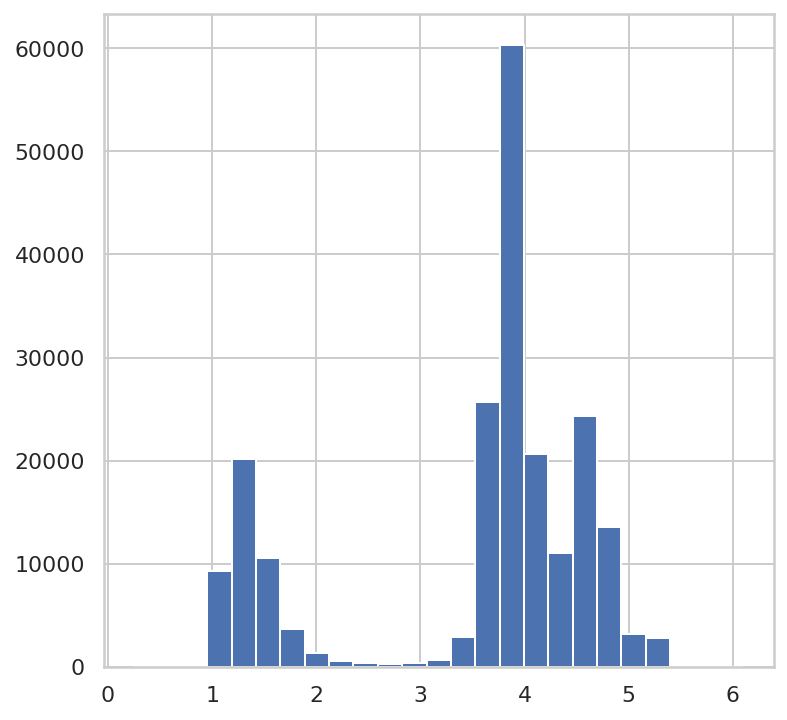

In [21]:
plt.figure(figsize=(6,6))
plt.hist(D,bins=25) ; 

## Bootstrap resampling 

We pick a subset of the overall sample `D`, repeat this procedure and compute the distribution of the *means* of our smaller subsets. 

In [60]:
bins = np.linspace(0.0, np.amax(D),25)

sample = []
for _ in range(10000):
    sample_n = np.random.choice(D, size=100000)
    sample.append(sample_n.mean()/2.0)
    

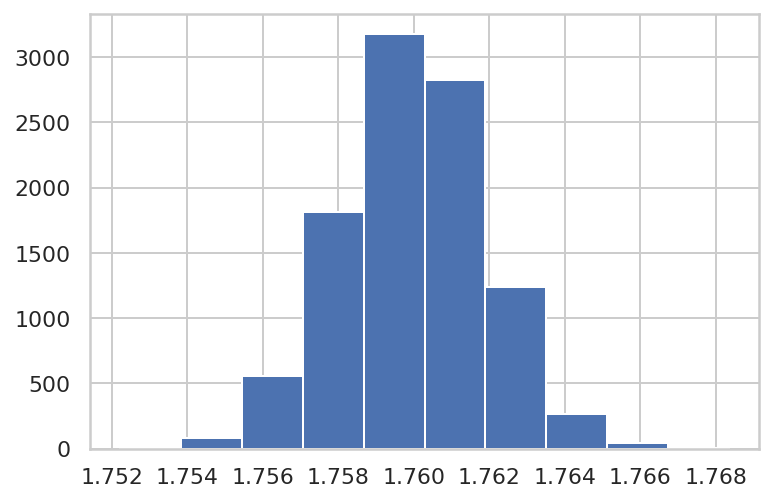

In [76]:
plt.hist(sample);


In [62]:
print(np.mean(sample), np.std(sample))

1.7599819921981046 0.0019093407047200718


## Bootstrap resampling of bin-heights

In [155]:
bins_boot = []
for _ in range(1000):
    sample_n = np.random.choice(D,size=200000)
    bin_entries_n , bin_edges_n = np.histogram(sample_n,bins=25)
    bins_boot.append(bin_entries_n)


(array([632.,   1.,   3.,  15.,  89., 102.,  84.,  44.,  23.,   7.]),
 array([ 1. ,  6.1, 11.2, 16.3, 21.4, 26.5, 31.6, 36.7, 41.8, 46.9, 52. ]),
 <a list of 10 Patch objects>)

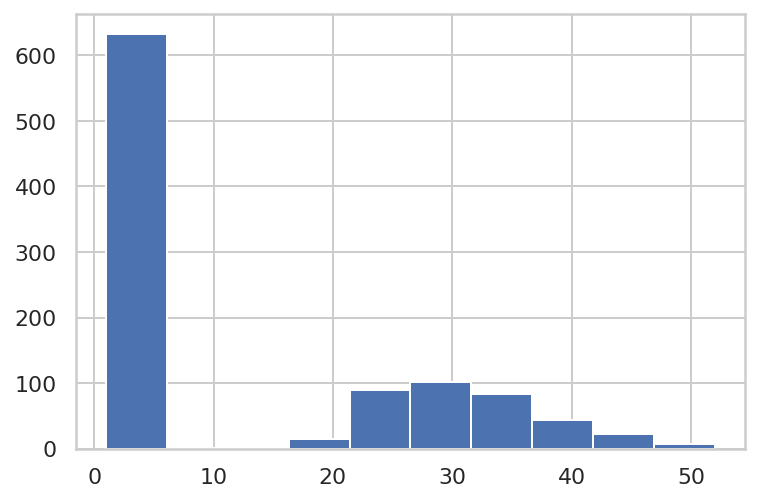

In [161]:
D1 = np.array(bins_boot)

bin_heights_mean = []
bin_heights_std = []

for i in range(25):
    mean_i = np.mean(D1[:,i])
    std_i = np.std(D1[:,i])
    bin_heights_mean.append(mean_i)
    bin_heights_std.append(std_i)   
    
plt.hist(D1[:,24])

In [157]:
sample_new = np.random.choice(D, size = 100000)
bins_1 = np.linspace(0.0, np.amax(sample_new), 25)
bins_2 = np.linspace(0.0, np.amax(sample_new), 26)

bins_centers = np.array([0.5 * (bins_2[i] + bins_2[i+1]) for i in range(len(bins_2)-1)])
heights = np.array(bin_heights_mean)
errors = np.array(bin_heights_std)

[1.0339600e+02 3.6688000e+01 1.5253100e+02 8.2265910e+03 1.8619162e+04
 1.0476287e+04 3.6944150e+03 1.3622600e+03 5.5335100e+02 3.0088700e+02
 2.3395100e+02 2.7979300e+02 5.2646500e+02 2.1170580e+03 1.8186516e+04
 5.0680153e+04 2.9084735e+04 1.0885225e+04 1.9087192e+04 1.6492007e+04
 5.1719010e+03 2.7198190e+03 9.2426500e+02 7.2472000e+01 1.2880000e+01]
[1.04728785e+01 6.08774638e+00 7.40073580e+01 1.38406112e+03
 4.60126445e+02 1.09619019e+03 4.13911417e+02 1.91028680e+02
 6.51691016e+01 2.74388453e+01 2.02744321e+01 3.61402013e+01
 1.12480900e+02 8.45146900e+02 8.76431591e+03 8.12892257e+03
 1.32061445e+04 8.74890811e+02 5.21353487e+03 5.14930337e+03
 2.96763867e+03 1.80622823e+02 1.00238585e+03 6.32456577e+01
 1.43571446e+01]


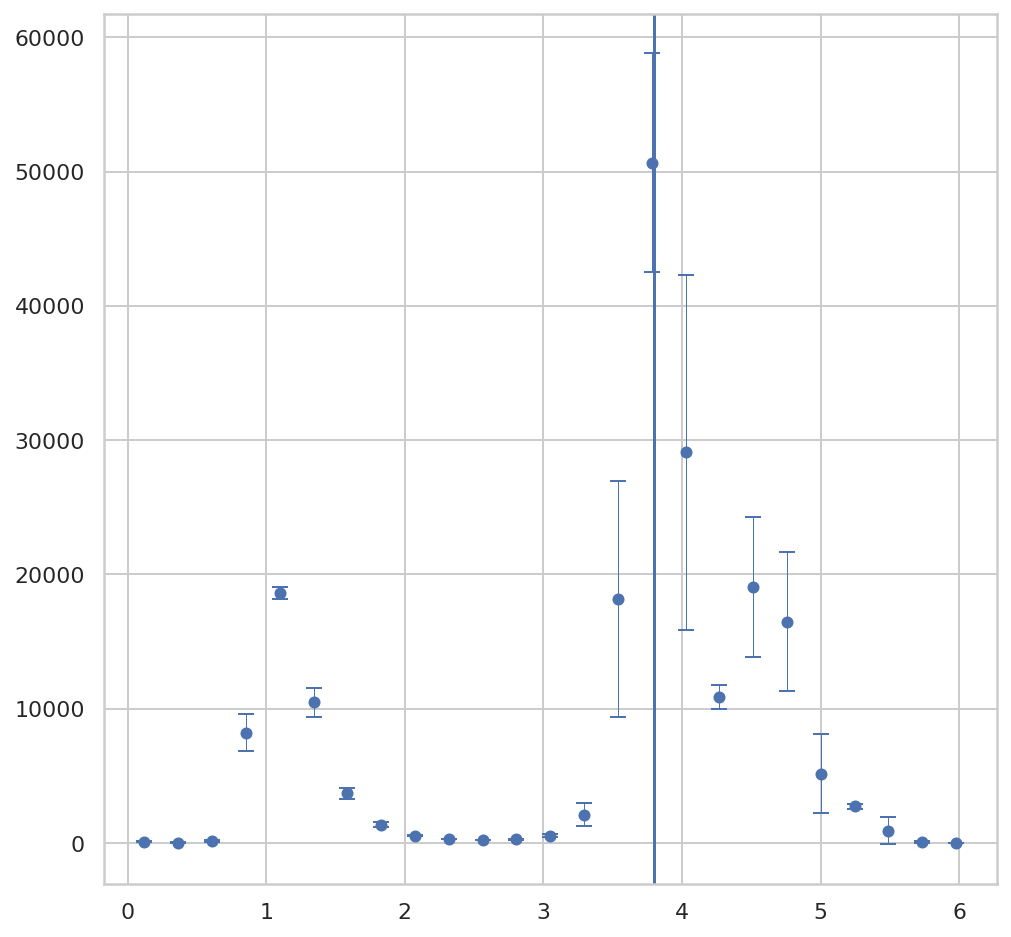

In [160]:
plt.figure(figsize=(8,8))
plt.errorbar(bins_centers, heights, yerr=errors, marker = 'o', markersize = 5.0 , 
            linestyle = 'none', elinewidth=0.5, capsize=4.0);
plt.axvline(3.8)
#plt.yscale('log', basey = 10);
print(heights);
print(errors);


## Things to do : 
- choose different sample size to reduce standard error
- maybe change number of bins to get better error bars
- rescale by 2.0 for all diameters 
- redo analysis and replot for other time slices
- compute PDFs and fit near tail region